<a href="https://colab.research.google.com/github/aseddin/F23_ECE4715/blob/main/5_support_vector_machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machines (SVMs)

Machine learning models are commonly employed for linear or nonlinear classification and regression tasks. What distinguishes Support Vector Machines (SVMs) is their unique capability not only to classify data points but also to maximize the margin between classes, thereby improving their generalization performance. SVMs excel in handling small to medium-sized nonlinear datasets, typically with instance counts ranging from hundreds to thousands. However, it's important to note that SVMs may face scalability challenges when applied to large datasets.

In [1]:
# code to set things up

# importing common libraries
import numpy as np
import pandas as pd

# Things related to figures and plots
# make figures look nicer
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:
# helper function(s)

# Plot a support vector classifier decision boundary with its margins
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
  w = svm_clf.coef_[0]
  b = svm_clf.intercept_[0]

  # At the decision boundary, w0*x0 + w1*x1 + b = 0
  # => x1 = -w0/w1 * x0 - b/w1

  x0 = np.linspace(xmin, xmax, 200)
  decision_boundary = -w[0] / w[1] * x0 - b / w[1]

  margin = 1/w[1]
  gutter_up = decision_boundary + margin
  gutter_down = decision_boundary - margin
  svs = svm_clf.support_vectors_

  plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
  plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
  plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
  plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors="#AAA", zorder=-1)

# Linear SVM Classification

The basic concept of SVM classifiers can be illustrated by an example with some figures. For this demonstration, we will focus on a linearly separable binary classification problem using the Iris dataset. Specifically, we will consider the "Setosa" and "Versicolor" classes due to their linear separability. To enhance visualization, we restrict our analysis to the "Petal Length" and "Petal Width" features, enabling the creation of informative plots.

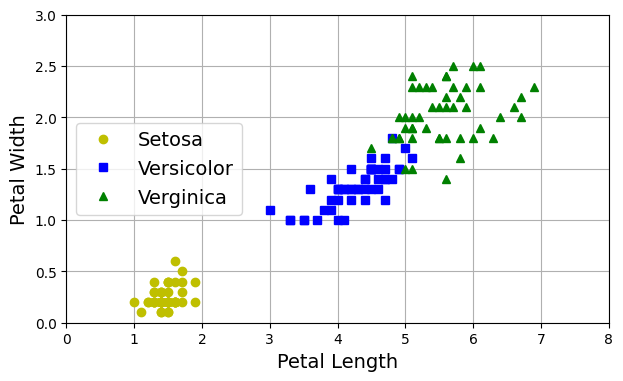

In [3]:
# Load & plot the Iris dataset
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target


# plot data
plt.figure(figsize=(7, 4))
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0],"yo", label="Setosa")
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1],"bs", label="Versicolor")
plt.plot(X[:, 0][y == 2], X[:, 1][y == 2],"g^", label="Verginica")
plt.legend(loc="center left")
plt.grid()
plt.axis([0, 8, 0, 3])
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.show()

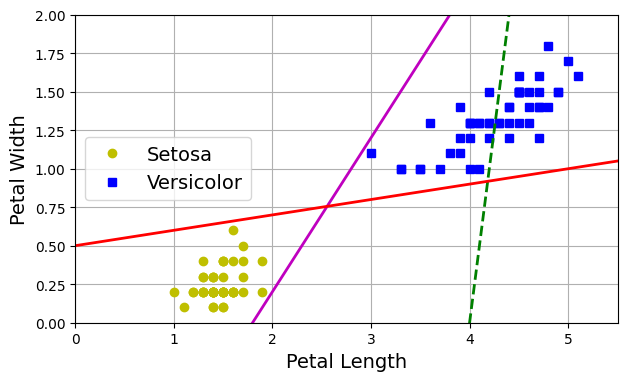

In [4]:
# keep the setosa and versicolor classes only (1 is versicolor)
setosa_or_versicolor = (y == 0) | (y == 1)
X_setosa_versicolor = X[setosa_or_versicolor]
y_setosa_versicolor = y[setosa_or_versicolor]

# fit some bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5 * x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

# plot data
plt.figure(figsize=(7, 4))
plt.plot(X_setosa_versicolor[:, 0][y_setosa_versicolor == 0],
         X_setosa_versicolor[:, 1][y_setosa_versicolor == 0],
         "yo", label="Setosa")
plt.plot(X_setosa_versicolor[:, 0][y_setosa_versicolor == 1],
         X_setosa_versicolor[:, 1][y_setosa_versicolor == 1],
         "bs", label="Versicolor")
plt.legend(loc="center left")
plt.grid()
plt.axis([0, 5.5, 0, 2])
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")

# plot decision boundaries
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.show()

The figure shows 3 potential classifiers:
  * The dashed green line is so bad that it cannot even separate the classes.
  * The magenta and red classifiers are acceptable; however, they might not generalize well, as their decision boundaries are too close to instances from each class.

Let's check what a linear SVM classifier can generate:


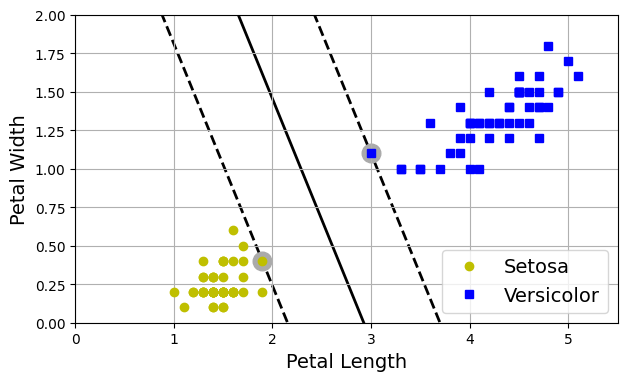

In [5]:
# Train and plot a linear SVM classifier
from sklearn.svm import SVC

svm_clf = SVC(kernel="linear", C=1e100)
svm_clf.fit(X_setosa_versicolor, y_setosa_versicolor)

# plot the decision boundary and the support vectors
plt.figure(figsize=(7, 4))
plot_svc_decision_boundary(svm_clf, 0, 5.5)

# plot data
plt.plot(X_setosa_versicolor[:, 0][y_setosa_versicolor == 0],
         X_setosa_versicolor[:, 1][y_setosa_versicolor == 0],
         "yo", label="Setosa")
plt.plot(X_setosa_versicolor[:, 0][y_setosa_versicolor == 1],
         X_setosa_versicolor[:, 1][y_setosa_versicolor == 1],
         "bs", label="Versicolor")
plt.legend(loc="lower right")
plt.grid()
plt.axis([0, 5.5, 0, 2])
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.show()


One can think of fitting an SVM classifier as fitting the widest possible street (parallel dashed lines above) between the classes.

The decision boundary (solid line) stays as far away from the closest training instances as possible. This is why it is sometimes called **large margin classification**

Adding more training instances "off the street" will not affect the decision boundary because it is fully determined (or **"supported"**) by instances located on the edge of the street (the support vectors) and they are highlighted in the figure above.

-----------
**NOTE**: SVMs are sensitive to feature scaling. When features exist on different scales, the resulting decision boundary is disproportionately influenced by the feature with the largest scale. This concern is demonstrated in the example below, where the vertical feature outweighs the horizontal one, leading to an SVM classifier that closely aligns with the horizon. To enhance the generalization of resulting decision boundaries, it is advisable to scale the features uniformly, such as using the `StandardScaler`.

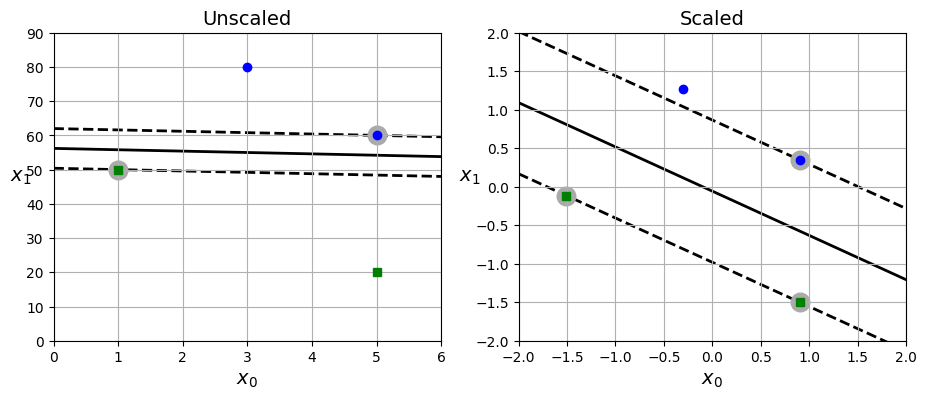

In [6]:
from sklearn.preprocessing import StandardScaler

# Generate artifical dataset where x0, x1 are on different scale
Xs = np.array([
    [1, 50],
    [5, 20],
    [3, 80],
    [5, 60]
]).astype(np.float64)

ys = np.array([
    0,
    0,
    1,
    1
])

# Scale the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)


# Train two SVC on the unscaled and scaled dataset
svm_clf = SVC(kernel="linear", C=1e100).fit(Xs, ys)
svm_clf_scaled = SVC(kernel="linear", C=1e100).fit(X_scaled, ys)

# plot the unscaled data and resulting decision boundary
plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.plot(Xs[:, 0][ys == 0], Xs[:, 1][ys == 0], "gs")
plt.plot(Xs[:, 0][ys == 1], Xs[:, 1][ys == 1], "bo")
plt.xlabel("$x_0$")
plt.ylabel("$x_1  $", rotation=0)
plt.title("Unscaled")
plt.grid()
plt.axis([0, 6, 0, 90])
plot_svc_decision_boundary(svm_clf, 0, 6)

# plot the scaled data and resulting decision boundary
plt.subplot(122)
plt.plot(X_scaled[:, 0][ys == 0], X_scaled[:, 1][ys == 0], "gs")
plt.plot(X_scaled[:, 0][ys == 1], X_scaled[:, 1][ys == 1], "bo")
plt.xlabel("$x_0$")
plt.ylabel("$x_1  $", rotation=0)
plt.title("Scaled")
plt.grid()
plt.axis([-2, 2, -2, 2])
plot_svc_decision_boundary(svm_clf_scaled, -2, 2)

plt.show()

## Soft Margin Classification

In the preceding sections of this notebook, we've utilized **hard margin classification** where all instances are strictly forced to stay off the street and on the correct side. However, this approach has its drawbacks:
1. It exclusively works when the data is linearly separable.
2. It is highly sensitive to outliers, leading to a narrower street and poor generalization, (this drawback can be caused by a single outlier).

To address these issues, the concept of **soft margin classification** comes into play. This strategy permits some **margin violations**, allowing instances to exist in the middle of the street or even on the wrong side. The key is to strike a balance between maintaining a wide street and limiting margin violations.

In `sklearn`, the regularization hyperparameter `C` provides control over the degree of margin violations:
* A low `C` yields a wider street and permits more margin violations, indicating a higher degree of regularization.
* Conversely, a large `C` results in a narrower street with fewer margin violations, indicating less regularization.

In instances where the SVC model exhibits underfitting or overfitting, adjusting the `C` parameter becomes a valuable tool for managing the bias/variance trade-off.

In [7]:
# generate 2 additional instances of the Setosa class
X_outliers = np.array([
    [3.4, 1.3],
    [3.2, 0.9]
])
y_outliers = np.array([
    0,
    0
])

# Not linearly separable dataset (Hard margin SVC does not work)
Xo1 = np.concatenate([X_setosa_versicolor, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y_setosa_versicolor, y_outliers[:1]], axis=0)

# Dataset with a single outlier
Xo2 = np.concatenate([X_setosa_versicolor, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y_setosa_versicolor, y_outliers[1:]], axis=0)

### Data that cannot be separated by a straight line

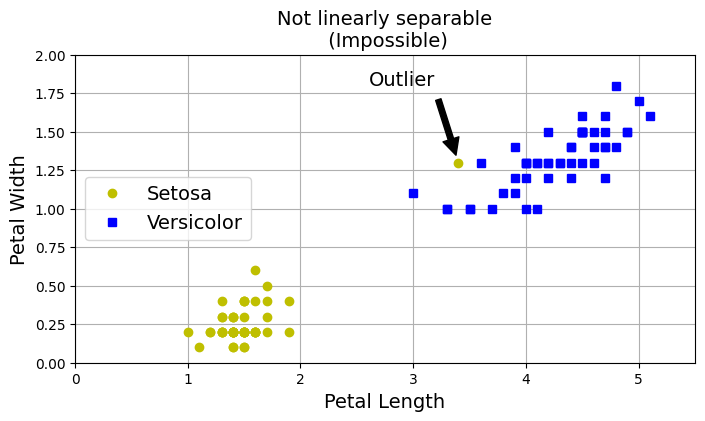

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo", label="Setosa")
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs", label="Versicolor")
plt.annotate(
    "Outlier",
    xy=(X_outliers[0][0], X_outliers[0][1]),
    xytext=(X_outliers[0][0] - 0.5, X_outliers[0][1] + 0.5),
    ha="center",
    arrowprops=dict(facecolor="black", shrink=0.1),
)
plt.grid()
plt.legend(loc="center left")
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.title("Not linearly separable\n (Impossible)")
plt.axis([0, 5.5, 0, 2])
plt.show()

In [9]:
svm_clf_impossible = SVC(kernel="linear", C=1e100, max_iter=1000).fit(Xo1, yo1)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### Influence of an outlier

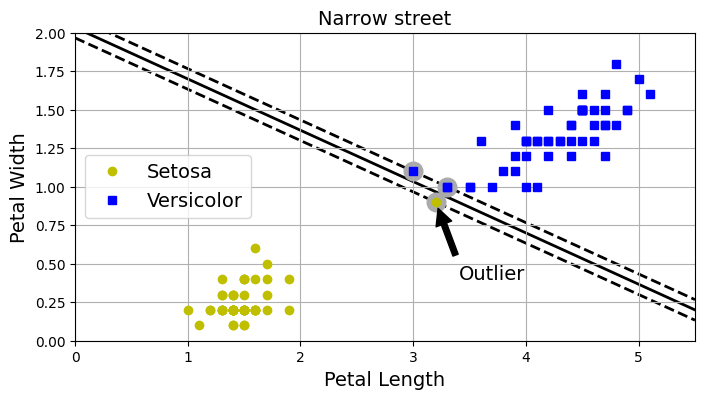

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo", label="Setosa")
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs", label="Versicolor")
plt.annotate(
    "Outlier",
    xy=(X_outliers[1][0], X_outliers[1][1]),
    xytext=(X_outliers[1][0] + 0.5, X_outliers[1][1] - 0.5),
    ha="center",
    arrowprops=dict(facecolor="black", shrink=0.1),
)
plt.grid()
plt.legend(loc="center left")
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.title("Narrow street")
plt.axis([0, 5.5, 0, 2])

# fit an SVC
svm_clf_outlier = SVC(kernel="linear", C=1e100).fit(Xo2, yo2)
plot_svc_decision_boundary(svm_clf_outlier, 0, 5.5)
plt.show()

### Effect of the `C` regularization hyperparameter

The Virginica class is not linearly separable, so we use it to show the effect of changing `C`

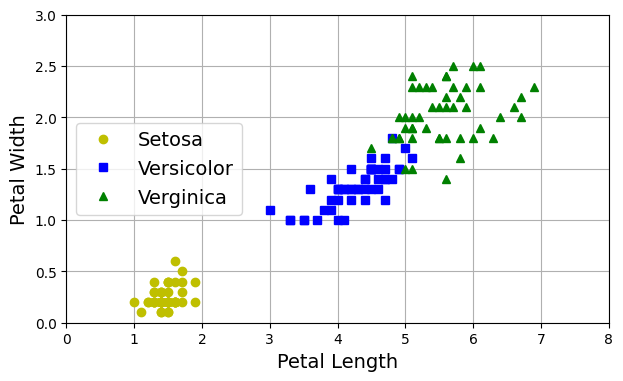

In [11]:
# plot the iris dataset
plt.figure(figsize=(7, 4))
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0],"yo", label="Setosa")
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1],"bs", label="Versicolor")
plt.plot(X[:, 0][y == 2], X[:, 1][y == 2],"g^", label="Verginica")
plt.legend(loc="center left")
plt.grid()
plt.axis([0, 8, 0, 3])
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.show()

In [12]:
# Binary classification probelm (Virginica/Not Virginica)

X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_verginica = (iris.target == 2)

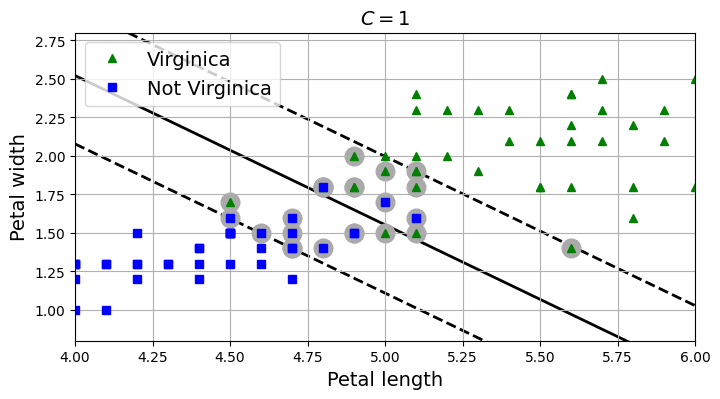

In [13]:
# Lower C allows more margin violation and wider street (less variance)
# Higher C allows less margin violation and narrower street (more variance)

#C = 1e-1
C = 1
#C = 100

svm_clf = SVC(kernel="linear", C=C)
svm_clf.fit(X, y_verginica)

plt.figure(figsize=(8, 4))
plt.plot(X[:, 0][y_verginica==1], X[:, 1][y_verginica==1], "g^", label="Virginica")
plt.plot(X[:, 0][y_verginica==0], X[:, 1][y_verginica==0], "bs", label="Not Virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title(f"$C = {svm_clf.C}$")
plt.axis([4, 6, 0.8, 2.8])
plt.grid()
plt.show()

In [14]:
# Testing a new instance
X_new = [
    [5.5, 1.7],
    [5.0, 1.5]
]
svm_clf.predict(X_new)

array([ True, False])

In [15]:
svm_clf.decision_function(X_new)

array([ 1.42243259, -0.11976094])

# Nonlinear SVM Classfication

SVMs are inherently designed as linear classifiers. Nonetheless, they can be used to address nonlinear datasets through various techniques. By employing methods such as kernel tricks or feature transformations, linear SVMs can effectively extend their applicability to capture complex nonlinear relationships within the data.

We will explore the following techniques:

* Polynomial Features
* Polynomial Kernel
* Similarity Features
* Gaussian RBF Kernel


In [16]:
# helper functions

def plot_dataset(X, y, axes):
  plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
  plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
  plt.axis(axes)
  plt.grid(True)
  plt.xlabel("$x_1$")
  plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
  x1s = np.linspace(axes[0], axes[1], 1000)
  x2s = np.linspace(axes[2], axes[3], 1000)
  x1, x2 = np.meshgrid(x1s, x2s)
  X = np.c_[x1.ravel(), x2.ravel()]
  y_pred = clf.predict(X).reshape(x1.shape)
  y_decision = clf.decision_function(X).reshape(x1.shape)
  plt.contourf(x1, x2, y_pred, cmap=plt.cm.brg, alpha=0.2)
  plt.contourf(x1, x2, y_decision, cmap=plt.cm.brg, alpha=0.1)


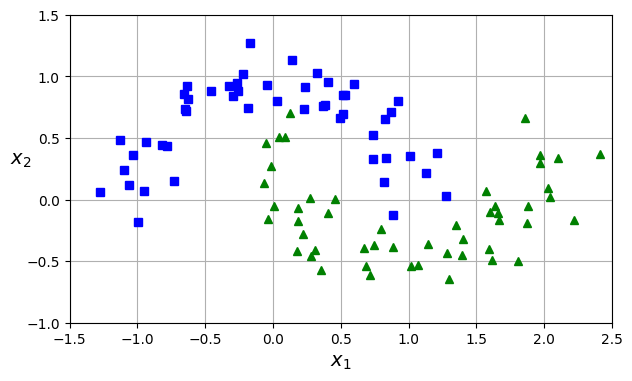

In [17]:
# Make two interleaving half circles (crescent moons)

from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

plt.figure(figsize=(7, 4))
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

## Polynomial Features

The use of `PolynomialFeatures` allows us to incorporate features up to a specified polynomial `degree`. It's important to note that while this method can be effective in capturing intricate relationships in the data, the potential combinatorial explosion of added features may lead to a slowdown in model training.

The following shows a simple example (9 instances total / 2 classes) of 1 dimensional and not linearly separable dataset. Adding a second feature $x_2 = x_1^2$ makes the resulting 2 dimensional data linearly separable

 X1  | y 
-----|---
-4.0 | 0 
-3.0 | 0 
-2.0 | 1 
-1.0 | 1 
 0.0 | 1 
 1.0 | 1 
 2.0 | 1 
 3.0 | 0 
 4.0 | 0 



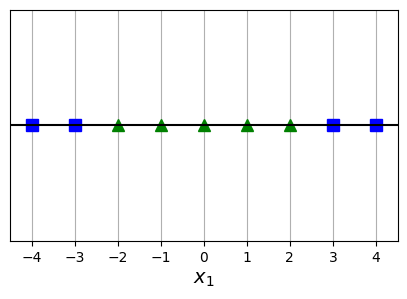

In [18]:
X1D = np.linspace(-4, 4, 9)
y1D = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

print(f"{'X1':^5}|{'y':^3}")
print(5 * "-" + "|" + 3 * "-")
for i, j in zip(X1D, y1D):
  print(f"{i:^5}|{j:^3}")

print()

plt.figure(figsize=(5, 3))
plt.plot(X1D[y1D==0], np.zeros(4), "bs", markersize=8)
plt.plot(X1D[y1D==1], np.zeros(5), "g^", markersize=8)
plt.gca().get_yaxis().set_ticks([])
plt.grid()
plt.axhline(y=0, color="k")
plt.xlabel("$x_1$")
plt.axis([-4.5, 4.5, -0.2, 0.2])
plt.show()

 X1    X2  | y 
----- -----|---
-4.0  16.0 | 0 
-3.0   9.0 | 0 
-2.0   4.0 | 1 
-1.0   1.0 | 1 
 0.0   0.0 | 1 
 1.0   1.0 | 1 
 2.0   4.0 | 1 
 3.0   9.0 | 0 
 4.0  16.0 | 0 



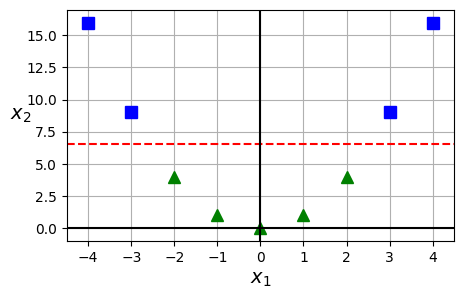

In [19]:
X2D = np.c_[X1D, X1D**2]

print(f"{'X1':^5} {'X2':^5}|{'y':^3}")
print(5 * "-" + " " + 5 * "-" + "|" + 3 * "-")
for i, j in zip(X2D, y1D):
  print(f"{i[0]:^5} {i[1]:^5}|{j:^3}")

print()

plt.figure(figsize=(5, 3))
plt.plot(X2D[:, 0][y1D==0], X2D[:, 1][y1D==0], "bs", markersize=8)
plt.plot(X2D[:, 0][y1D==1], X2D[:, 1][y1D==1], "g^", markersize=8)
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--")
plt.grid()
plt.axhline(y=0, color="k")
plt.axvline(x=0, color="k")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axis([-4.5, 4.5, -1, 17])
plt.show()

We now apply the same concept to the moons dataset, adding 3rd degree polynomials then scaling the features before training a linear SVM classifier

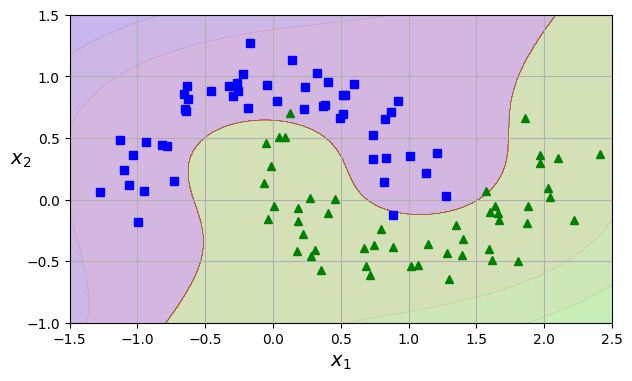

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    SVC(kernel="linear", C=10, max_iter=10000, random_state=42)
)

polynomial_svm_clf.fit(X, y)

plt.figure(figsize=(7, 4))
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plt.show()

In [21]:
# get the names of the generated polynomial features
polynomial_svm_clf[0].get_feature_names_out()

array(['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1',
       'x0 x1^2', 'x1^3'], dtype=object)

## Polynomial Kernel

Kernel tricks are mathematical techniques that enable us to achieve the same outcome as adding numerous features without the need to actually include any new feature. This implies that the number of features remains constant, and the model's speed does not decrease (as compared to the linear case).

In the `SVC` class, the kernel can be specified using the `kernel` parameter. When using `kernel='poly'`, you have the flexibility to designate the desired polynomial degree through the `degree` parameter. Additionally, the hyperparameter `coef0` allows you to control the extent to which the model is influenced by high-degree terms versus low-degree terms.

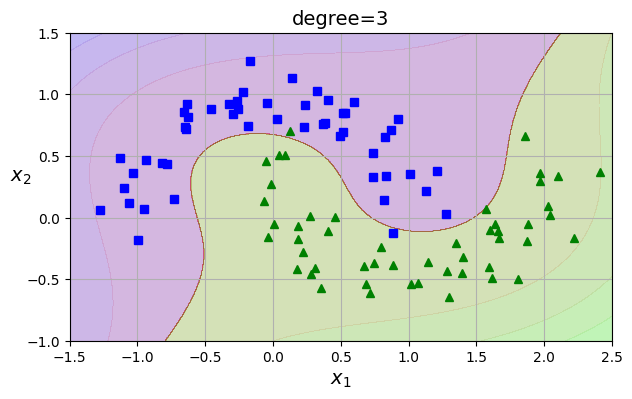

In [22]:
degree = 3
#degree = 15
#degree = 100

poly_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=degree, coef0=1, C=5, max_iter=10000, random_state=42)
)

poly_kernel_svm_clf.fit(X, y)

plt.figure(figsize=(7, 4))
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plt.title(f"degree={degree}")
plt.show()

## Similarity Features

We can handle nonlinear datasets by adding features computed using a similarity function instead of higher polynomial degrees. A similarity function measures how each instance in the dataset resembles a particular landmark. A landmark can be any instance (or instances) in the dataset itself.

A commonly used similarity function is the Gaussian Radial Basis Function (Gaussian RBF):

$$
k(a, b) = e^{-\gamma ||a - b||^2 }
$$

$\gamma$ controls the amount of desired similarity. Larger values result in narrower bell-shaped curve (inverse of $\sigma$)

There are different approaches for selecting a landmark, but the simplest is to create a landmark at each and every instance within the training dataset. If you have $m$ instances, each with $n$ features, you will be generating $m$ features (assuming you  drop the original $n$ features). This means the transformed dataset will have $m$ instances, each with $m$ features. This method increases the likelihood of making the training set linearly separable. If the training set is very large, the transformed training set will have an equally large number of features.

In [23]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

The following plot shows the values generated by the Gaussian RBF for 2 landmarks (highlighted in red). The largest similarity value is 1 at the corresponding landmark and the similarity gets smaller as we move away from the landmark. $\gamma$ controls the width of the Gaussian bell curve.

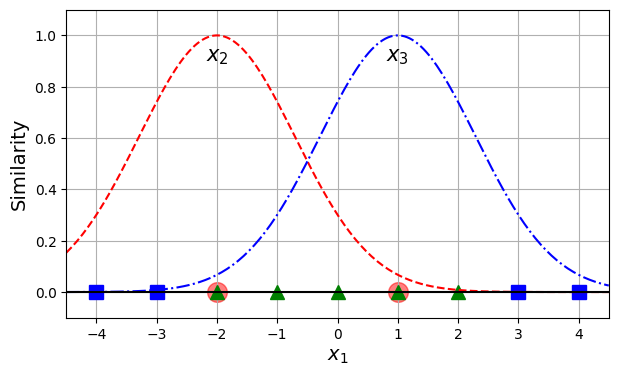

In [24]:
gamma = 0.3
#gamma = 10

landmark1 = X1D[2]
landmark2 = X1D[5]

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, landmark1, gamma)
x3s = gaussian_rbf(x1s, landmark2, gamma)

plt.figure(figsize=(7, 4))
plt.plot(X1D[y1D==0], np.zeros(4), "bs", markersize=10)
plt.plot(X1D[y1D==1], np.zeros(5), "g^", markersize=10)
plt.scatter(x=[landmark1, landmark2], y=[0, 0], s=200, alpha=0.5, c="red")
plt.text(landmark1, 0.9, "$x_2$", ha="center", fontsize=15)
plt.text(landmark2, 0.9, "$x_3$", ha="center", fontsize=15)
plt.plot(x1s, x2s, "r--")
plt.plot(x1s, x3s, "b-.")
plt.grid()
plt.axhline(y=0, color="k")
plt.xlabel("$x_1$")
plt.ylabel("Similarity")
plt.axis([-4.5, 4.5, -0.1, 1.1])
plt.show()

At $x_1 = -1$, the similarities with the 2 landmarks are:

In [25]:
print(f"Similarity with the first landmark: {landmark1}")
print(gaussian_rbf(np.array([-1]).reshape(-1, 1), landmark1, gamma))

Similarity with the first landmark: -2.0
[0.74081822]


In [26]:
print(f"Similarity with the second landmark: {landmark2}")
print(gaussian_rbf(np.array([-1]).reshape(-1, 1), landmark2, gamma))

Similarity with the second landmark: 1.0
[0.30119421]


We can transform the original dataset and drop the original features.

Landmark1: -2.0
Landmark2: 1.0

 X1    X2    X3  | y 
----- ----- -----|---
-4.00 0.30  0.00 | 0 
-3.00 0.74  0.01 | 0 
-2.00 1.00  0.07 | 1 
-1.00 0.74  0.30 | 1 
0.00  0.30  0.74 | 1 
1.00  0.07  1.00 | 1 
2.00  0.01  0.74 | 1 
3.00  0.00  0.30 | 0 
4.00  0.00  0.07 | 0 



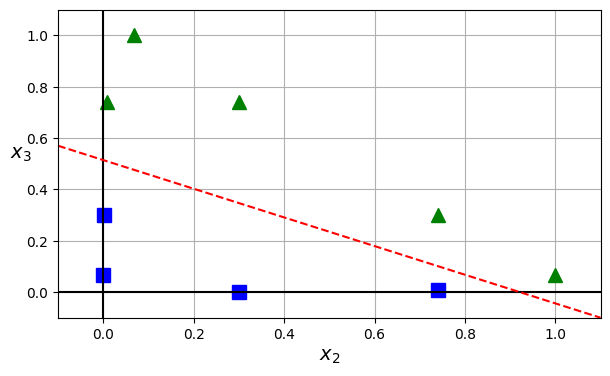

In [27]:
gamma = 0.3

landmark1 = X1D[2]
landmark2 = X1D[5]

print("Landmark1:", landmark1)
print("Landmark2:", landmark2)
print()

# compute the new features
XK = np.c_[gaussian_rbf(X1D.reshape(-1, 1), landmark1, gamma), gaussian_rbf(X1D.reshape(-1, 1), landmark2, gamma)]

print(f"{'X1':^5} {'X2':^5} {'X3':^5}|{'y':^3}")
print(5 * "-" + " " + 5 * "-" + " " + 5 * "-" + "|" + 3 * "-")
for x1, i, j in zip(X1D, XK, y1D):
  print(f"{x1:^5.2f} {i[0]:^5.2f} {i[1]:^5.2f}|{j:^3}")

print()

plt.figure(figsize=(7, 4))
plt.plot(XK[:, 0][y1D==0], XK[:, 1][y1D==0], "bs", markersize=10)
plt.plot(XK[:, 0][y1D==1], XK[:, 1][y1D==1], "g^", markersize=10)
plt.grid()
plt.axhline(y=0, color="k")
plt.axvline(x=0, color="k")
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--")
plt.xlabel("$x_2$")
plt.ylabel("$x_3$", rotation=0)
plt.axis([-0.1, 1.1, -0.1, 1.1])
plt.show()

## Gaussian RBF Kernel

Similar to the Polynomial Kernel trick, we can use the similarity function technique (i.e. Gaussian RBF) without actually having to generate new features. All we need to do is to use a Gaussian RBF Kernel.

`SVC` models with `kernel="rbf"` have 2 hyperparameters that can be used for regularization:

* `gamma`
  * Increasing `gamma` makes the bell curve narrower and the effect of each instance is therefore smaller. The decision boundary is more irregular and tries to classify each instance correctly (higher variance)
  * Decreasing `gamma` makes the bell curve wider and the effect of each instance is larger. The decision boundary is smoother. (lower variance)
* `C` is regularization hyperparameter
   * Increasing `C` reduces regularization
   * Decreasing `C` increases regularization

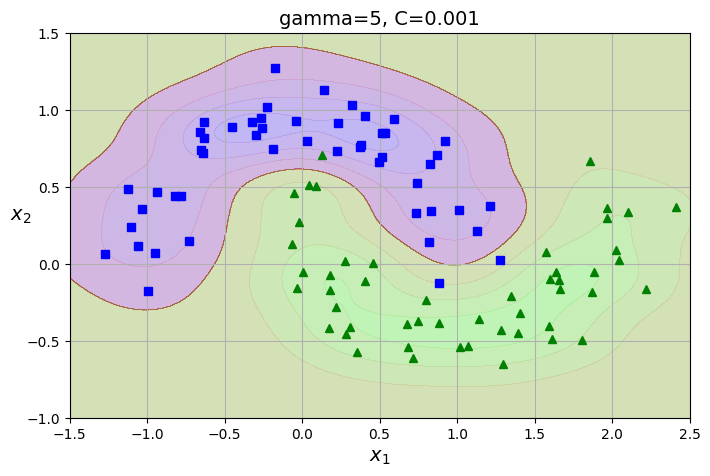

In [28]:
gamma = 5
#gamma = 35

C = 0.001
#C = 1

rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=gamma, C=C)
)

rbf_kernel_svm_clf.fit(X, y)

plt.figure(figsize=(8, 5))
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plot_predictions(rbf_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plt.title(f"gamma={gamma}, C={C}")
plt.show()

# `SVC` vs `LinearSVC` Time Complexity

So far we only used the `SVC` class, which is based on the `libsvm` library. We used it with different kernels (i.e. `linear`, `poly`, `rbf`). The training time complexity is between $\mathcal{O}(m^2 \times n)$ and $\mathcal{O}(m^3 \times n)$ which doesn't scale with larger datasets (i.e. large $m$)

`sklearn` provides an alternative class `LinearSVC` that doesn't accept any kernels and is only used in the linear case. This class is based on the `liblinear` library and its training time complexity is about $\mathcal{O}(m \times n)$ which is faster than `SVC` with `kernel=linear`

If you plan on using a linear SVM with a large training set, you should plan on using `LinearSVC`

# SVM Regression

In SVM classification, our goal is to find the widest possible street between two classes while minimizing margin violations. However, by tweaking the objective, SVM can also be used for regression. In SVM regression, the aim is to fit as many instances as possible directly on the street, while limiting margin violations (instances positioned _off_ the street). The width of the street in this context is controlled by a hyperparameter $\epsilon$. Decreasing $\epsilon$ (resulting in a narrower street) increases the number of support vectors, referring to instances either off the street or located on its edge. This, in turn, contributes to regularization of the model (i.e. increases regularization).


`SVR` for regression is similar to `SVC` for classification, as both support kernelization. Similarly, `LinearSVR` for regression corresponds to `LinearSVC` for classification, both designed explicitly for linear scenarios and without the ability to accept kernels. While `LinearSVR` and `LinearSVC` excel in speed compared to their counterparts `SVR` and `SVC`, it's important to note that they are suitable only for linear scenarios.

In [29]:
# helper functions

# Find the original unscaled values of the support vectors
def find_suppor_vectors(svm_reg, X, y):
  y_pred = svm_reg.predict(X)
  epsilon = svm_reg[-1].epsilon
  off_margin = np.abs(y - y_pred) >= epsilon
  return np.argwhere(off_margin)


# plot SVM regression
def plot_svm_regression(svm_reg, X, y, axes, plot_epsilon=False):
  x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
  y_pred = svm_reg.predict(x1s)
  epsilon = svm_reg[-1].epsilon
  plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$", zorder=-2)
  plt.plot(x1s, y_pred + epsilon, "k--", zorder=-2)
  plt.plot(x1s, y_pred - epsilon, "k--", zorder=-2)
  plt.scatter(X[svm_reg._support], y[svm_reg._support], s=180,
              facecolor='#AAA', zorder=-1)
  plt.plot(X, y, "bo")
  if (plot_epsilon):
    xt = x1s[50].reshape(-1, 1)
    yt = svm_reg.predict(xt)
    plt.annotate(
        '', xy=(xt, yt), xycoords='data',
        xytext=(xt, yt - epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
    plt.text(xt - 0.1, yt - epsilon,r"$\epsilon$", fontsize=16)
  plt.title(f"$\epsilon={epsilon}$")
  plt.legend(loc="upper left")
  plt.grid()
  plt.axis(axes)

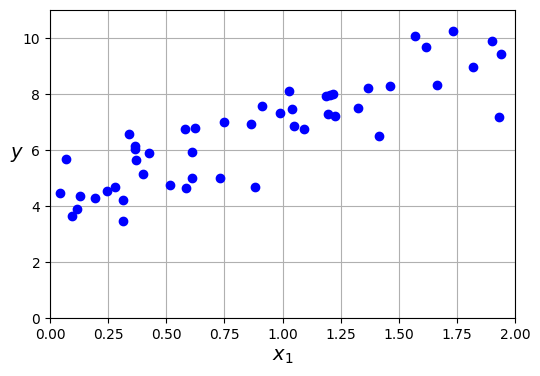

In [30]:
# generate linear looking data

theta0 = 4
theta1 = 3

np.random.seed(42)
X = 2 * np.random.rand(50, 1)
y = theta0 + theta1 * X[:, 0] + np.random.randn(50)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "bo")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 11])
plt.grid()
plt.show()

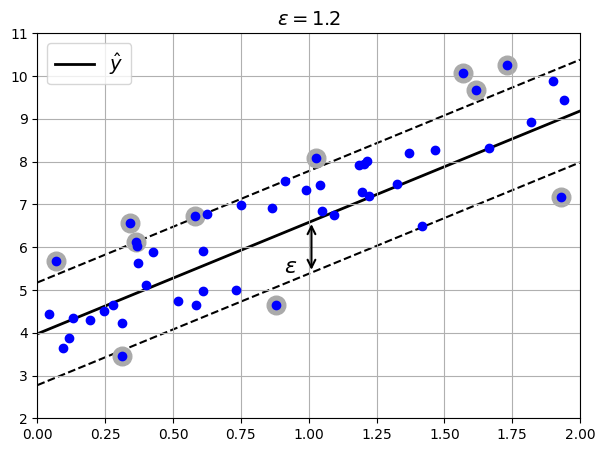

In [31]:
from sklearn.svm import LinearSVR

epsilon=1.2
#epsilon=0.4

svm_reg = make_pipeline(
    StandardScaler(),
    LinearSVR(epsilon=epsilon, random_state=42)
)

svm_reg.fit(X, y)

svm_reg._support = find_suppor_vectors(svm_reg, X, y)
plt.figure(figsize=(7, 5))
plot_svm_regression(svm_reg, X, y, [0, 2, 2, 11], plot_epsilon=True)

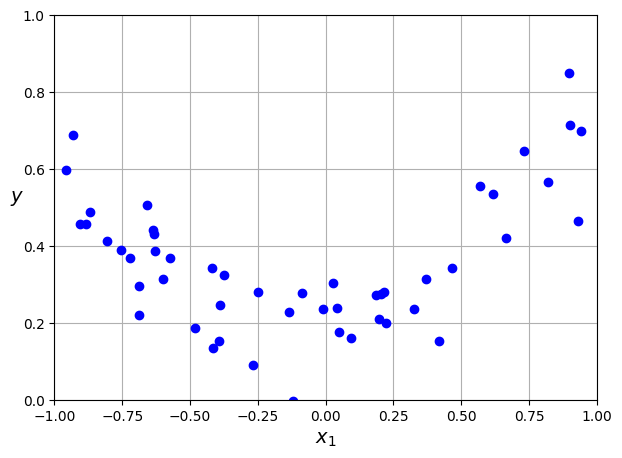

In [32]:
# generate non-linear quadratic  data

theta0 = 0.2
theta1 = 0.1
theta2 = 0.5

np.random.seed(42)
X = 2 * np.random.rand(50, 1) - 1
y = theta0 + theta1 * X[:, 0] + theta2 * X[:, 0] ** 2 + np.random.randn(50) / 10

plt.figure(figsize=(7, 5))
plt.plot(X, y, "bo")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-1, 1, 0, 1])
plt.grid()
plt.show()

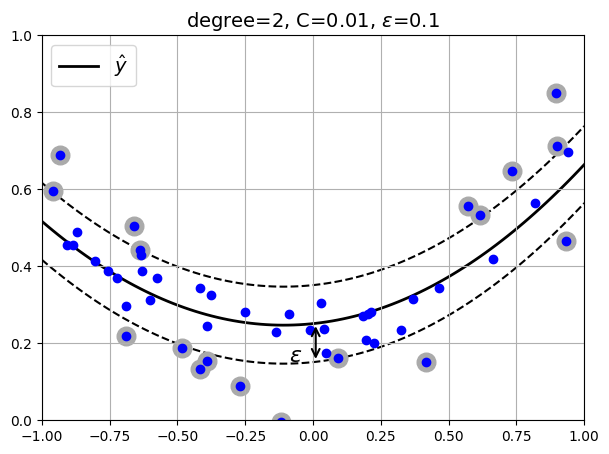

In [33]:
from sklearn.svm import SVR

degree = 2
C = 0.01
epsilon = 0.1

svm_poly_reg = make_pipeline(
    StandardScaler(),
    SVR(kernel="poly", degree=degree, C=C, epsilon=epsilon)
)

svm_poly_reg.fit(X, y)
svm_poly_reg._support = find_suppor_vectors(svm_poly_reg, X, y)
plt.figure(figsize=(7, 5))
plot_svm_regression(svm_poly_reg, X, y, [0-1, 1, 0, 1], plot_epsilon=True)
plt.title(f"degree={degree}, C={C}, $\epsilon$={epsilon}")
plt.show()